In [333]:
import csv
import re
import pandas as pd
import numpy as np
import math
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
from astropy.nddata import Cutout2D
import matplotlib.cm as cm
import scipy.misc
import scipy.stats as sta
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')
import plotly.graph_objects as go
import plotly

In [334]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

In [335]:
def calculate_flux_density(mag):
    flux_density=10**((48.6+mag)/(-2.5))
    return flux_density

def calculate_intensity(mag,corresponding_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    return intensity

def calculate_flux(mag,corresponding_lambda,delta_lambda):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    return flux

def calculate_distance(redshift):
    distance=redshift*3e5/70
    distance=distance*9.4607e17
    distance=distance*3.2616e6
    return(distance)

In [336]:
def calculate_continuum_flux_density(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    return continuum_flux_density

def calculate_continuum_subtracted_line_flux(flux_bw,flux_nb,delta_lambda_bw,delta_lambda_nb):
    continuum_flux_density=(flux_bw-flux_nb)/(delta_lambda_bw-delta_lambda_nb)
    continuum_subtracted_line_flux=flux_nb-continuum_flux_density*delta_lambda_nb
    return continuum_subtracted_line_flux

In [337]:
def calculate_SB(mag,corresponding_lambda,delta_lambda,area):
    flux_density=10**((48.6+mag)/(-2.5))
    intensity=(flux_density*3e8*1e10)/(corresponding_lambda**2)
    flux=intensity*delta_lambda
    surface_brightness=flux/(area*0.25*0.25)
    return surface_brightness
    
# unit： erg per second per quare centimeter per suqare arcsec

In [338]:
def CountPixel(img, x, y, boundary, lenth = 30):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    return len(np.where(img > boundary)[0])

In [339]:
def choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return False
    return True

def wrong_choose(img,x,y,thresholds,lenth):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    for j in range(len(img)):
        for i in range(len(img[0])):
            if img[j][i]<thresholds:
                return True
    return False

In [340]:
with open("BOSS1441_NB.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('nbcut2.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [341]:
with open("BOSS1441_Bw.csv",'w+',newline='') as csvfile:
    spamwriter = csv.writer(csvfile, dialect='excel')
    with open('bwcut2.cat','r',encoding = 'utf-8') as f:
        linelist = f.readlines()[13:]
        spamwriter.writerow(['NUMBER','X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000',\
                            'FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE'])
        for line in linelist:
            line_list = line.strip('\n').split()
            spamwriter.writerow(line_list)

In [342]:
SDSS6=pd.read_csv("SDSS6.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25])
BOSS1441_Bw=pd.read_csv("BOSS1441_Bw.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])
#index_col=False
BOSS1441_NB=pd.read_csv("BOSS1441_NB.csv",usecols=[1,2,3,4,5,6,7,8,9,10,11,12])

In [343]:
SDSS6=pd.concat([SDSS6,(SDSS6['umag']-0.8116*(SDSS6['umag'] - SDSS6['gmag']) + 0.1313)],axis=1)


SDSS6.columns=['_RAJ2000', '_DEJ2000',  'RA_ICRS',  'DE_ICRS',     'mode',   'q_mode',\
          'class',   'SDSS12', 'm_SDSS!2',  'ObsDate',        'Q',     'umag',\
         'e_umag',     'gmag',   'e_gmag',     'rmag',   'e_rmag',     'imag',\
         'e_imag',     'zmag',   'e_zmag',      'zsp',      'zph',    'e_zph',\
          '<zph>',          'bmag']


In [344]:
coord_sdss=SkyCoord(ra=SDSS6['_RAJ2000']*u.degree, dec=SDSS6['_DEJ2000']*u.degree)
coord_bw=SkyCoord(ra=BOSS1441_Bw['ALPHA_J2000']*u.degree, dec=BOSS1441_Bw['DELTA_J2000']*u.degree)
coord_nb=SkyCoord(ra=BOSS1441_NB['ALPHA_J2000']*u.degree, dec=BOSS1441_NB['DELTA_J2000']*u.degree)

In [345]:
idx, d2d, d3d = coord_sdss.match_to_catalog_sky(coord_bw)
index = np.where((d2d < Angle('0d00m0.5s'))&(SDSS6['bmag'] < 20)&(SDSS6['bmag'] > 16.5))
idx=idx[index]

SDSS6_RAJ2000=SDSS6._RAJ2000.data.obj
SDSS6_DEJ2000=SDSS6._DEJ2000.data.obj
SDSS6_bmag=SDSS6.bmag.data.obj
BOSS1441_Bw_list=BOSS1441_Bw.MAG_APER.data.obj
BOSS1441_Bw_list_standard=BOSS1441_Bw.MAG_APER.data.obj[idx]


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [346]:
SDSS6_bmag_standard=SDSS6_bmag[index]
zeropoint_bw=SDSS6_bmag_standard-BOSS1441_Bw_list_standard
zeropoint_bw=sigma_clip(zeropoint_bw, sigma=3, iters=10)

Bw的zeropoint为 25.135089261052638
Bw的standard deviation为 0.06016703340401998


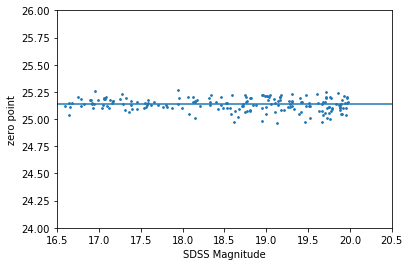

In [347]:
# zeropoint_bw.zeropoint_bw.data.obj
zp_bw=np.mean(zeropoint_bw)#Bw的zeropoint
zp_std_bw=np.std(zeropoint_bw)#Bw的standard deviation


print('Bw的zeropoint为',zp_bw)
print('Bw的standard deviation为',zp_std_bw)

plt.axhline(zp_bw)
plt.xlabel('SDSS Magnitude')
plt.ylabel('zero point')
plt.scatter(x=SDSS6_bmag_standard,y=zeropoint_bw,s=3)
plt.axis([16.5, 20.5, 24, 26])
plt.show()


In [348]:
BOSS1441_Bw=pd.concat([BOSS1441_Bw,BOSS1441_Bw.MAG_APER+zp_bw],axis=1)
BOSS1441_Bw.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

In [349]:
idx_nb, d2d_nb, d3d_nb = coord_nb.match_to_catalog_sky(coord_bw)
index_nb = np.where(d2d_nb < Angle('0d0m02s'))
idx_nb=idx_nb[index_nb]

In [350]:
BOSS1441_NB_match = BOSS1441_NB.MAG_APER.data.obj[index_nb]
#这是全部的可以与NB中对应成功的NB中的源的现在的nb_magnitude,包括galaxy和star
index_zp = np.where((BOSS1441_NB_match < 5) &(BOSS1441_NB_match > 0))
#这是全部可以用来计算zeropoint的NB的点

mid=BOSS1441_Bw.standard_mag.data.obj[idx_nb]
mag_bw_standard_select=mid[index_zp]#这里面写出来的则是与下面那个对应的bw中的标准的magnitude
mag_nb_standard_select=BOSS1441_NB_match[index_zp]#这里面写出来是标准的nb的magnitude

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [351]:
mag_nb_standard_select=sigma_clip(mag_nb_standard_select,sigma=1, iters=10)
zp_nb=np.mean(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))
zp_std_nb=np.std(sigma_clip(mag_bw_standard_select-mag_nb_standard_select,sigma=1, iters=10))

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning:

Series.data is deprecated and will be removed in a future version



NB的zeropoint为 22.16936926105264
NB的standard deviation为 0.0025071098898932216


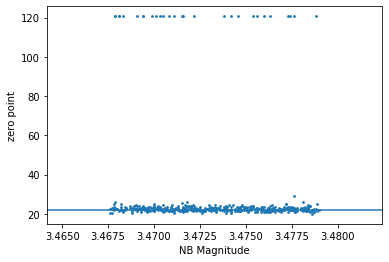

In [352]:
print('NB的zeropoint为',zp_nb)
print('NB的standard deviation为',zp_std_nb)

BOSS1441_NB=pd.concat([BOSS1441_NB,BOSS1441_NB.MAG_APER+zp_nb],axis=1)
BOSS1441_NB.columns=['X_IMAGE','Y_IMAGE','ALPHA_J2000','DELTA_J2000','FLUX_APER','FLUXERR_APER','MAG_APER','MAGERR_APER ','FLAGS','NITER_MODEL','ISOAREA_IMAGE','ISOAREAF_IMAGE','standard_mag']

BOSS1441_NB_match=BOSS1441_NB_match+zp_nb

b_nb=BOSS1441_Bw.standard_mag.data.obj[idx_nb]-BOSS1441_NB_match
mag_nb_draw=BOSS1441_NB_match

plt.axhline(zp_nb)
plt.xlabel('NB Magnitude')
plt.ylabel('zero point')
plt.scatter(x=mag_nb_standard_select,y=mag_bw_standard_select-mag_nb_standard_select,s=3)
#plt.axis([2.835,2.853,18,40])
plt.show()


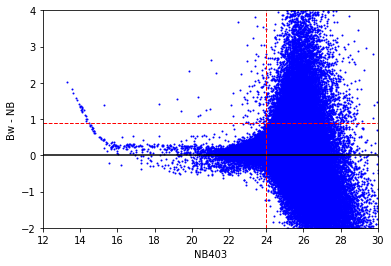

In [353]:
plt.scatter(mag_nb_draw, b_nb, color = 'b', s=1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(24, color='r', linestyle='--', linewidth = 1)
plt.axis([12,30,-2,4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [354]:
BOSS1441_Bw_ALPHA=BOSS1441_Bw.ALPHA_J2000.data.obj[idx_nb]
BOSS1441_Bw_DELTA=BOSS1441_Bw.DELTA_J2000.data.obj[idx_nb]
BOSS1441_Bw_X_IMAGE=BOSS1441_Bw.X_IMAGE.data.obj[idx_nb]
BOSS1441_Bw_Y_IMAGE=BOSS1441_Bw.Y_IMAGE.data.obj[idx_nb]
BOSS1441_Bw_ISOAREAF_IMAGE=BOSS1441_Bw.ISOAREAF_IMAGE.data.obj[idx_nb]

BOSS1441_NB_ALPHA=BOSS1441_NB.ALPHA_J2000.data.obj[index_nb]
BOSS1441_NB_DELTA=BOSS1441_NB.DELTA_J2000.data.obj[index_nb]
BOSS1441_NB_X_IMAGE=BOSS1441_NB.X_IMAGE.data.obj[index_nb]
BOSS1441_NB_Y_IMAGE=BOSS1441_NB.Y_IMAGE.data.obj[index_nb]
BOSS1441_NB_ISOAREAF_IMAGE=BOSS1441_NB.ISOAREAF_IMAGE.data.obj[index_nb]


/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning:

Series.data is deprecated and will 

In [355]:
with open("BOSS1441_Bw.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(idx_nb)):
        if (BOSS1441_Bw.standard_mag.data.obj[idx_nb][i]-BOSS1441_NB_match[i] > 0.9) \
        & (BOSS1441_NB_match[i]< 24):
            txtfile.write('circle(')
            txtfile.write(str(BOSS1441_Bw_ALPHA[i]))
            txtfile.write(',')
            txtfile.write(str(BOSS1441_Bw_DELTA[i]))
            txtfile.write(',2.821")\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [356]:
with open("BOSS1441_NB.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(idx_nb)):
        if (BOSS1441_Bw.standard_mag.data.obj[idx_nb][i]-BOSS1441_NB_match[i] > 0.9) \
        & (BOSS1441_NB_match[i]< 24):
            txtfile.write('circle(')
            txtfile.write(str(BOSS1441_NB_ALPHA[i]))
            txtfile.write(',')
            txtfile.write(str(BOSS1441_NB_DELTA[i]))
            txtfile.write(',2.821")\n')

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [357]:
BOSS1441_Bw_X_IMAGE_dubious=[]
BOSS1441_Bw_Y_IMAGE_dubious=[]
BOSS1441_Bw_RA_dubious=[]
BOSS1441_Bw_DEC_dubious=[]
BOSS1441_Bw_mag_dubious=[]
BOSS1441_Bw_AREA_dubious=[]

BOSS1441_NB_X_IMAGE_dubious=[]
BOSS1441_NB_Y_IMAGE_dubious=[]
BOSS1441_NB_RA_dubious=[]
BOSS1441_NB_DEC_dubious=[]
BOSS1441_NB_mag_dubious=[]
BOSS1441_NB_AREA_dubious=[]

for i in range(len(idx_nb)):
    if (BOSS1441_Bw.standard_mag.data.obj[idx_nb][i]-BOSS1441_NB_match[i] > 0.9) \
        & (BOSS1441_NB_match[i]< 24):
        BOSS1441_Bw_X_IMAGE_dubious.append(BOSS1441_Bw_X_IMAGE[i])
        BOSS1441_Bw_Y_IMAGE_dubious.append(BOSS1441_Bw_Y_IMAGE[i])
        BOSS1441_Bw_RA_dubious.append(BOSS1441_Bw_ALPHA[i])
        BOSS1441_Bw_DEC_dubious.append(BOSS1441_Bw_DELTA[i])
        BOSS1441_Bw_mag_dubious.append(BOSS1441_Bw.standard_mag.data.obj[idx_nb][i])
        BOSS1441_Bw_AREA_dubious.append(BOSS1441_Bw_ISOAREAF_IMAGE[i])
        
        BOSS1441_NB_X_IMAGE_dubious.append(BOSS1441_NB_X_IMAGE[i])
        BOSS1441_NB_Y_IMAGE_dubious.append(BOSS1441_NB_Y_IMAGE[i])
        BOSS1441_NB_RA_dubious.append(BOSS1441_NB_ALPHA[i])
        BOSS1441_NB_DEC_dubious.append(BOSS1441_NB_DELTA[i])
        BOSS1441_NB_mag_dubious.append(BOSS1441_NB_match[i])
        BOSS1441_NB_AREA_dubious.append(BOSS1441_NB_ISOAREAF_IMAGE[i])

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: FutureWarning:

Series.data is deprecated and will be removed in a future version

/Users/jiangtianxiaoyubei/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: FutureWarning:

Series.data is deprecated and will be removed in a future version



In [358]:
#一个pixel的尺度是0.24999916 arcsec，近似为0.25 arcsec，则单个pixel的面积是0.062499580000706 arcsec^2，近似为0.0625arcsec^2
#假设判定是Layman-Alpha nebula的面积是25 arcsec^2
#那么一个layman-alpha nebula对应至少400个像素
#我们取900个，也就是30×30

In [359]:
w = WCS('bwcut.fits')
data,header=fits.getdata('bwcut.fits',header=True)
data2,header2=fits.getdata('nbcut.fits',header=True)
lenx=len(data[0])
leny=len(data)

datacut=10**((zp_bw - zp_nb)/2.5) * data2-data
norm = Scaleimgconverter(datacut)

In [360]:
x_select=[]
y_select=[]
ra_select=[]
dec_select=[]
mag_nb_select=[]
mag_bw_select=[]
area_select=[]
bw_area_select=[]
for i in range(len(BOSS1441_NB_X_IMAGE_dubious)):
    if (BOSS1441_NB_AREA_dubious[i]>25) and (choose(datacut,BOSS1441_NB_X_IMAGE_dubious[i],BOSS1441_NB_Y_IMAGE_dubious[i],-10,30)):
        x_select.append(BOSS1441_NB_X_IMAGE_dubious[i])
        y_select.append(BOSS1441_NB_Y_IMAGE_dubious[i])
        ra_select.append(BOSS1441_NB_RA_dubious[i])
        dec_select.append(BOSS1441_NB_DEC_dubious[i])
        mag_nb_select.append(BOSS1441_NB_mag_dubious[i])
        mag_bw_select.append(BOSS1441_Bw_mag_dubious[i])
        area_select.append(BOSS1441_NB_AREA_dubious[i])
        bw_area_select.append(BOSS1441_Bw_AREA_dubious[i])


In [361]:
def show_nebula(img1,img2,img3,x,y,size):
    norm1 = Scaleimgconverter(img1)
    norm2 = Scaleimgconverter(img2)
    norm3 = Scaleimgconverter(img3)
    center=[np.array([x],float),np.array([y],float)]
    cutout1=Cutout2D(data, center,30, wcs = WCS(header))
    cutout2=Cutout2D(data2, center,30, wcs = WCS(header))
    cutout3=Cutout2D(datacut, center,30, wcs = WCS(header))
  
    x = x.astype(int)
    y = y.astype(int)
    x1=x-size
    x2=x+size
    y1=y-size
    y2=y+size
    fig = plt.figure()
    ax = plt.subplot(131,projection=cutout1.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img1[y1:y2,x1:x2],norm=norm1,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')
    
    fig = plt.figure()
    ax = plt.subplot(132,projection=cutout2.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img2[y1:y2,x1:x2],norm=norm2,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

    fig = plt.figure()
    ax = plt.subplot(133,projection=cutout3.wcs)
    ax.set_xlabel('RA')
    ax.set_ylabel('Dec')
    ax.imshow(img3[y1:y2,x1:x2],norm=norm3,cmap=plt.cm.gray)
    ra = ax.coords[0]
    ra.set_major_formatter('hh:mm:ss')
    dec = ax.coords[1]
    dec.set_major_formatter('dd:mm:ss')

In [362]:
nb_flux=[]
bw_flux=[]

for i in range(len(mag_nb_select)):
    nb_flux.append(calculate_flux(mag_nb_select[i],4030,45))
    
for i in range(len(mag_bw_select)):
    bw_flux.append(calculate_flux(mag_bw_select[i],4135,1278))

In [363]:
line_flux=[]
for i in range(len(nb_flux)):
    line_flux.append(calculate_continuum_subtracted_line_flux(bw_flux[i],nb_flux[i],1278,48))

In [364]:
distance=calculate_distance(2.3)

In [365]:
lya_luminosity=[]
for i in range(len(mag_nb_select)):
    lya_luminosity.append(4*math.pi*distance**2*line_flux[i])
print(lya_luminosity)

[9.954549691516859e+41, 1.2920943093622827e+42, 1.509477579795225e+42, 8.99768017547464e+41, 1.408407327594965e+42, 1.863619748071118e+42, 8.105641952124049e+41, 5.949464987528095e+41, 7.578064710171864e+41, 1.7672922983892074e+42, 9.221331839156081e+41, 2.64975515141847e+42, 8.598231048191588e+41, 3.659196100949264e+42, 9.65362217452669e+42, 2.1830631033355498e+42, 8.864007209446663e+41, 1.2493017334525089e+42, 1.6525115580511372e+43, 2.0074171630077877e+42, 1.6487898472749768e+42, 1.5478118142592846e+43, 1.6860594647957147e+42, 5.941211029244313e+41, 6.194477378367795e+41, 3.540354399989393e+42, 1.3294361363408703e+42, 2.758912331564935e+42, 7.32791835593021e+41, 1.369816378690512e+42, 6.820016654784835e+41, 1.3661378257901605e+42, 8.728575463396822e+41, 6.544749071348491e+41, 9.61662746380705e+41, 1.1264438633526346e+42, 9.158121819438041e+41, 2.140823345135471e+42, 9.470218924850538e+41, 7.886188185802935e+41, 1.000065263607529e+42, 3.6359267238025504e+43, 1.1171317938763156e+42, 7

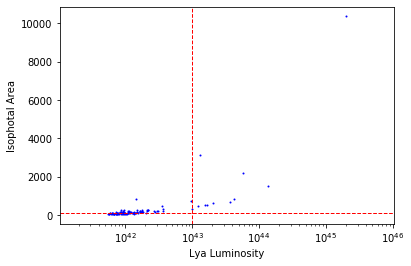

In [394]:
plt.semilogx()
plt.scatter(lya_luminosity,area_select, color = 'b', s=1)
plt.axhline(100, color='r', linestyle='--', linewidth = 1)
plt.axvline(1e43, color='r', linestyle='--', linewidth = 1)
plt.xlabel('Lya Luminosity')
plt.ylabel('Isophotal Area')
plt.show()

In [395]:
x_final=[]
y_final=[]
ra_final=[]
dec_final=[]
mag_nb_final=[]
mag_bw_final=[]
area_nb_final=[]
area_bw_final=[]
ra_final_min=[]
dec_final_min=[]

for i in range(len(x_select)):
    if (lya_luminosity[i]> 1e43) and (area_select[i]> 100):
        x_final.append(x_select[i])
        y_final.append(y_select[i])
        ra_final.append(ra_select[i])
        dec_final.append(dec_select[i])
        mag_nb_final.append(mag_nb_select[i])
        mag_bw_final.append(mag_bw_select[i])
        area_nb_final.append(area_select[i])
        area_bw_final.append(bw_area_select[i])

print(len(x_final))

11


In [396]:
surface_brightness_bw=[]
surface_brightness_nb=[]
for i in range(len(x_final)):
    surface_brightness_bw.append(calculate_SB(mag_bw_select[i],4135,1278,area_bw_final[i]))
    surface_brightness_nb.append(calculate_SB(mag_nb_select[i],4030,45,area_nb_final[i]))

x_image: 3442.1711 

y_image: 1359.5455 

RA: 220.31627680000003 

DEC: 39.8201211 

nb_magnitude 20.348569261052642 

bw_magnitude: 21.42738926105264 

surface_brightness_bw: 6.186834212072758e-57 

surface_brightness_nb: 2.3886739686657086e-18 



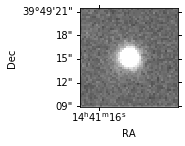

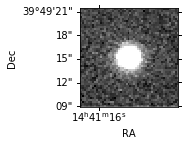

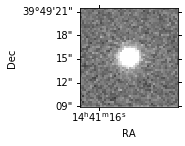

In [397]:
show_nebula(data,data2,datacut,x_final[0],y_final[0],25)
print('x_image:',x_final[0],'\n')
print('y_image:',y_final[0],'\n')
print('RA:',ra_final[0],'\n')
print('DEC:',dec_final[0],'\n')
print('nb_magnitude',mag_nb_final[0],'\n')
print('bw_magnitude:', mag_bw_final[0],'\n')
print('surface_brightness_bw:',surface_brightness_bw[0],'\n')
print('surface_brightness_nb:',surface_brightness_nb[0],'\n')

x_image: 4295.1099 

y_image: 1517.6484 

RA: 220.23912760000002 

DEC: 39.8309973 

nb_magnitude 20.43326926105264 

bw_magnitude: 21.535189261052636 

surface_brightness_bw: 9.549005799250587e-17 

surface_brightness_nb: 5.426329850719605e-18 



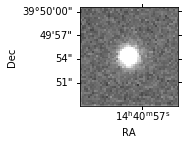

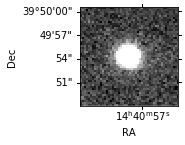

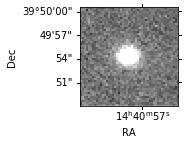

In [398]:
show_nebula(data,data2,datacut,x_final[1],y_final[1],25)
print('x_image:',x_final[1],'\n')
print('y_image:',y_final[1],'\n')
print('RA:',ra_final[1],'\n')
print('DEC:',dec_final[1],'\n')
print('nb_magnitude',mag_nb_final[1],'\n')
print('bw_magnitude:', mag_bw_final[1],'\n')
print('surface_brightness_bw:',surface_brightness_bw[1],'\n')
print('surface_brightness_nb:',surface_brightness_nb[1],'\n')

x_image: 3950.4133 

y_image: 2520.9226 

RA: 220.27013190000002 

DEC: 39.9007162 

nb_magnitude 19.86496926105264 

bw_magnitude: 22.18768926105264 

surface_brightness_bw: 1.0250363687668753e-16 

surface_brightness_nb: 4.385442633047431e-18 



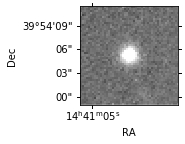

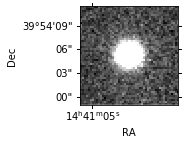

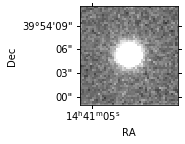

In [399]:
show_nebula(data,data2,datacut,x_final[2],y_final[2],25)
print('x_image:',x_final[2],'\n')
print('y_image:',y_final[2],'\n')
print('RA:',ra_final[2],'\n')
print('DEC:',dec_final[2],'\n')
print('nb_magnitude',mag_nb_final[2],'\n')
print('bw_magnitude:', mag_bw_final[2],'\n')
print('surface_brightness_bw:',surface_brightness_bw[2],'\n')
print('surface_brightness_nb:',surface_brightness_nb[2],'\n')

x_image: 4670.0093 

y_image: 2543.0989 

RA: 220.20498840000002 

DEC: 39.9021467 

nb_magnitude 19.19516926105264 

bw_magnitude: 20.747789261052638 

surface_brightness_bw: 2.3973134025123786e-17 

surface_brightness_nb: 7.514209866229402e-19 



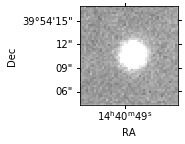

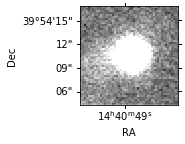

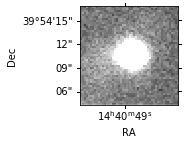

In [400]:
show_nebula(data,data2,datacut,x_final[3],y_final[3],25)
print('x_image:',x_final[3],'\n')
print('y_image:',y_final[3],'\n')
print('RA:',ra_final[3],'\n')
print('DEC:',dec_final[3],'\n')
print('nb_magnitude',mag_nb_final[3],'\n')
print('bw_magnitude:', mag_bw_final[3],'\n')
print('surface_brightness_bw:',surface_brightness_bw[3],'\n')
print('surface_brightness_nb:',surface_brightness_nb[3],'\n')

x_image: 1240.9962 

y_image: 3736.9045 

RA: 220.51549419999998 

DEC: 39.9852448 

nb_magnitude 15.28696926105264 

bw_magnitude: 16.680089261052636 

surface_brightness_bw: 4.554773114583833e-19 

surface_brightness_nb: 2.0140657578476654e-19 



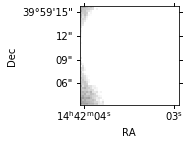

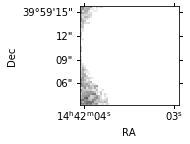

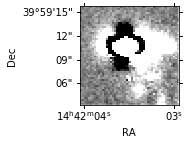

In [401]:
show_nebula(data,data2,datacut,x_final[4],y_final[4],25)
print('x_image:',x_final[4],'\n')
print('y_image:',y_final[4],'\n')
print('RA:',ra_final[4],'\n')
print('DEC:',dec_final[4],'\n')
print('nb_magnitude',mag_nb_final[4],'\n')
print('bw_magnitude:', mag_bw_final[4],'\n')
print('surface_brightness_bw:',surface_brightness_bw[4],'\n')
print('surface_brightness_nb:',surface_brightness_nb[4],'\n')

x_image: 3848.9131 

y_image: 4191.6445 

RA: 220.27905800000002 

DEC: 40.0167506 

nb_magnitude 20.78086926105264 

bw_magnitude: 22.03568926105264 

surface_brightness_bw: 5.1091147948427586e-17 

surface_brightness_nb: 6.5940891399631864e-18 



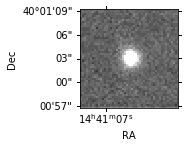

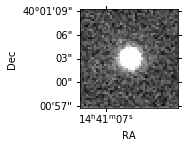

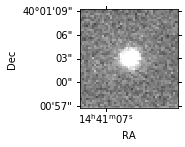

In [402]:
show_nebula(data,data2,datacut,x_final[5],y_final[5],25)
print('x_image:',x_final[5],'\n')
print('y_image:',y_final[5],'\n')
print('RA:',ra_final[5],'\n')
print('DEC:',dec_final[5],'\n')
print('nb_magnitude',mag_nb_final[5],'\n')
print('bw_magnitude:', mag_bw_final[5],'\n')
print('surface_brightness_bw:',surface_brightness_bw[5],'\n')
print('surface_brightness_nb:',surface_brightness_nb[5],'\n')

x_image: 2618.8359 

y_image: 4361.7017 

RA: 220.3905883 

DEC: 40.0286546 

nb_magnitude 19.41536926105264 

bw_magnitude: 20.63768926105264 

surface_brightness_bw: 9.440314422386392e-18 

surface_brightness_nb: 1.4625073670849439e-18 



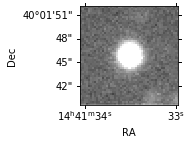

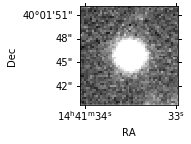

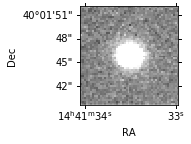

In [405]:
show_nebula(data,data2,datacut,x_final[6],y_final[6],25)
print('x_image:',x_final[6],'\n')
print('y_image:',y_final[6],'\n')
print('RA:',ra_final[6],'\n')
print('DEC:',dec_final[6],'\n')
print('nb_magnitude',mag_nb_final[6],'\n')
print('bw_magnitude:', mag_bw_final[6],'\n')
print('surface_brightness_bw:',surface_brightness_bw[6],'\n')
print('surface_brightness_nb:',surface_brightness_nb[6],'\n')

x_image: 3173.4475 

y_image: 4666.1147 

RA: 220.340261 

DEC: 40.049765 

nb_magnitude 20.99576926105264 

bw_magnitude: 22.27608926105264 

surface_brightness_bw: 6.628776190327824e-17 

surface_brightness_nb: 4.2457160372701775e-18 



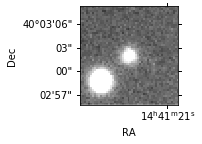

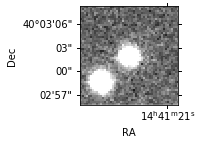

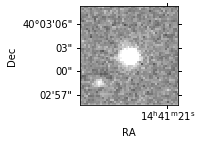

In [406]:
show_nebula(data,data2,datacut,x_final[7],y_final[7],25)
print('x_image:',x_final[7],'\n')
print('y_image:',y_final[7],'\n')
print('RA:',ra_final[7],'\n')
print('DEC:',dec_final[7],'\n')
print('nb_magnitude',mag_nb_final[7],'\n')
print('bw_magnitude:', mag_bw_final[7],'\n')
print('surface_brightness_bw:',surface_brightness_bw[7],'\n')
print('surface_brightness_nb:',surface_brightness_nb[7],'\n')

x_image: 3050.3552 

y_image: 4711.5049 

RA: 220.3514241 

DEC: 40.0529255 

nb_magnitude 21.01586926105264 

bw_magnitude: 23.64238926105264 

surface_brightness_bw: 3.161438956338388e-17 

surface_brightness_nb: 5.247252748473971e-19 



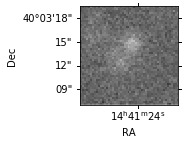

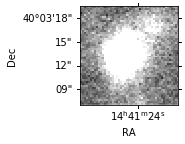

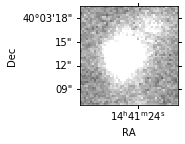

In [408]:
show_nebula(data,data2,datacut,x_final[8],y_final[8],25)
print('x_image:',x_final[8],'\n')
print('y_image:',y_final[8],'\n')
print('RA:',ra_final[8],'\n')
print('DEC:',dec_final[8],'\n')
print('nb_magnitude',mag_nb_final[8],'\n')
print('bw_magnitude:', mag_bw_final[8],'\n')
print('surface_brightness_bw:',surface_brightness_bw[8],'\n')
print('surface_brightness_nb:',surface_brightness_nb[8],'\n')

x_image: 2686.3848 

y_image: 5533.7612 

RA: 220.3844037 

DEC: 40.110045 

nb_magnitude 20.32656926105264 

bw_magnitude: 21.941589261052638 

surface_brightness_bw: 5.317629246173837e-17 

surface_brightness_nb: 5.068128098843685e-18 



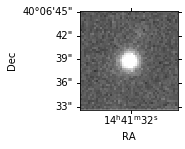

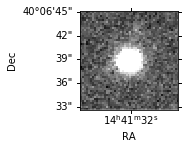

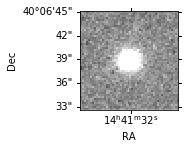

In [409]:
show_nebula(data,data2,datacut,x_final[9],y_final[9],25)
print('x_image:',x_final[9],'\n')
print('y_image:',y_final[9],'\n')
print('RA:',ra_final[9],'\n')
print('DEC:',dec_final[9],'\n')
print('nb_magnitude',mag_nb_final[9],'\n')
print('bw_magnitude:', mag_bw_final[9],'\n')
print('surface_brightness_bw:',surface_brightness_bw[9],'\n')
print('surface_brightness_nb:',surface_brightness_nb[9],'\n')

x_image: 5633.9194 

y_image: 6787.4146 

RA: 220.116367 

DEC: 40.1966816 

nb_magnitude 18.23136926105264 

bw_magnitude: 19.647689261052637 

surface_brightness_bw: 6.118121130156455e-18 

surface_brightness_nb: 9.40084115833706e-19 



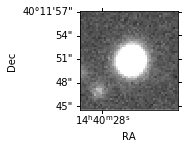

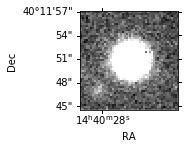

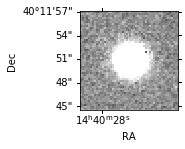

In [410]:
show_nebula(data,data2,datacut,x_final[10],y_final[10],25)
print('x_image:',x_final[10],'\n')
print('y_image:',y_final[10],'\n')
print('RA:',ra_final[10],'\n')
print('DEC:',dec_final[10],'\n')
print('nb_magnitude',mag_nb_final[10],'\n')
print('bw_magnitude:', mag_bw_final[10],'\n')
print('surface_brightness_bw:',surface_brightness_bw[10],'\n')
print('surface_brightness_nb:',surface_brightness_nb[10],'\n')

In [412]:
#check with unaided eyes
del x_final[4]
del y_final[4]
del ra_final[4]
del dec_final[4]
del mag_nb_final[4]
del mag_bw_final[4]
del area_nb_final[4]
del area_bw_final[4]

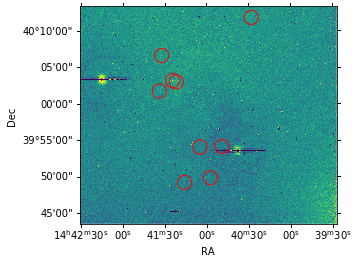

<Figure size 432x288 with 0 Axes>

In [413]:
ax = plt.subplot(projection=WCS(header))
fig = plt.figure()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.imshow(datacut, origin='lower',norm=norm,cmap=plt.cm.viridis)
ra = ax.coords[0]
ra.set_major_formatter('hh:mm:ss')
dec = ax.coords[1]
dec.set_major_formatter('dd:mm:ss')
ax.scatter(x_final, y_final, color='', marker='o', edgecolors='r', s=200)

In [414]:
with open("BOSS1441_cut.coord.reg",'w+',newline='') as txtfile:
    txtfile.write('# Region file format: DS9 version 4.1\n')
    txtfile.write('global color=green dashlist=8 3 width=1 font="helvetica 10 normal roman" select=1 highlite=1 dash=0 fixed=0 edit=1 move=1 delete=1 include=1 source=1\n')
    txtfile.write('fk5\n')
    for i in range(len(x_select)):
        txtfile.write('circle(')
        txtfile.write(str(ra_select[i]))
        txtfile.write(',')
        txtfile.write(str(dec_select[i]))
        txtfile.write(',2.821")\n')

In [415]:
x_emitter=[]
y_emitter=[]
ra_emitter=[]
dec_emitter=[]

for i in range(len(x_select)):
    x_emitter.append(x_select[i])
    y_emitter.append(y_select[i])
    ra_emitter.append(ra_select[i])
    dec_emitter.append(dec_select[i])


219.79083071999997 220.70409408000003 39.684355620000005 40.26914658


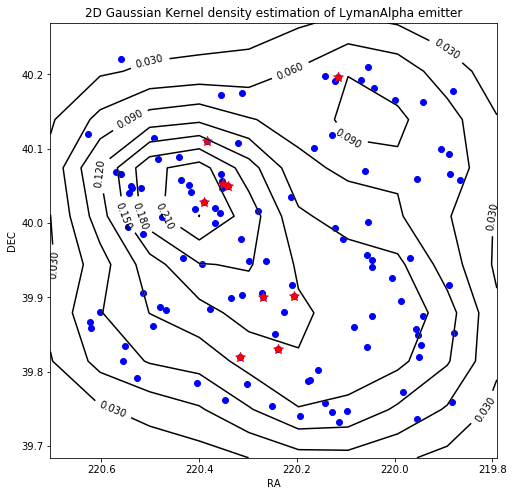

In [416]:
# Extract x and y
x = ra_emitter
y = dec_emitter
# Define the borders
deltaX = (max(x) - min(x))/10
deltaY = (max(y) - min(y))/10
xmin = min(x) - deltaX
xmax = max(x) + deltaX
ymin = min(y) - deltaY
ymax = max(y) + deltaY
print(xmin, xmax, ymin, ymax)

coeff=((xmax-xmin)*(ymax-ymin)*36)

# Use Gauss Kernel Function f（x）=A·exp[-（x-x'）**2/sigma**2]
#x‘——centre
#sigma——bandwidth， default value： n**(-1./(d+4)), in which d is the Number of dimensions,n is the Number of datapoints.
#!maybe we need a more reasonalbe value of bandwidth


# Create meshgrid
xx, yy = np.mgrid[xmin:xmax:10j, ymin:ymax:10j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])
kernel = sta.gaussian_kde(values)
f = np.reshape(kernel(positions).T, xx.shape)/coeff
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
ax.set_xlim(xmax, xmin)
ax.set_ylim(ymin, ymax)
cfset = ax.contour(xx, yy, f,colors='w')
ax.scatter(ra_emitter,dec_emitter,c='b')
#ax.imshow(np.rot90(f), extent=[xmin, xmax, ymin, ymax])
#ax.imshow(np.rot90(f),cmap='coolwarm', extent=[xmin, xmax, ymin, ymax])
cset = ax.contour(xx, yy, f, colors='black')
ax.clabel(cset, inline=1, fontsize=10)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
plt.title('2D Gaussian Kernel density estimation of LymanAlpha emitter')
ax.scatter(ra_final,dec_final, c='r', s=100, marker='*')

In [417]:
#不好用，图一乐完了
'''
data = [
    go.Histogram2dContour(
        x = x,
        y = y,
        histnorm='density',
        ncontours=8,
        colorscale = 'Blues',
        reversescale = False,
        xaxis = 'x',
        yaxis = 'y'
    ),
    go.Scatter(
        x = x,
        y = y,
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'blue',
            size = 5
        ),
    ),
    go.Scatter(
        x = ra_final_min,
        y = dec_final_min,
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'red',
            size = 10
        ),
    )
]
'''

"\ndata = [\n    go.Histogram2dContour(\n        x = x,\n        y = y,\n        histnorm='density',\n        ncontours=8,\n        colorscale = 'Blues',\n        reversescale = False,\n        xaxis = 'x',\n        yaxis = 'y'\n    ),\n    go.Scatter(\n        x = x,\n        y = y,\n        xaxis = 'x',\n        yaxis = 'y',\n        mode = 'markers',\n        marker = dict(\n            color = 'blue',\n            size = 5\n        ),\n    ),\n    go.Scatter(\n        x = ra_final_min,\n        y = dec_final_min,\n        xaxis = 'x',\n        yaxis = 'y',\n        mode = 'markers',\n        marker = dict(\n            color = 'red',\n            size = 10\n        ),\n    )\n]\n"

In [418]:
'''
layout = go.Layout(
    autosize = False,
    xaxis = dict(
        title='RA',
        zeroline = False,
        domain = [0,0.85],
        showgrid = False,
        range=[xmax, xmin]
    ),
    yaxis = dict(
        title='DEC',
        zeroline = False,
        domain = [0,0.85],
        showgrid = False,
        range=[ymin, ymax]
    ),
    
    height = 800,
    width = 800,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False
)
'''

"\nlayout = go.Layout(\n    autosize = False,\n    xaxis = dict(\n        title='RA',\n        zeroline = False,\n        domain = [0,0.85],\n        showgrid = False,\n        range=[xmax, xmin]\n    ),\n    yaxis = dict(\n        title='DEC',\n        zeroline = False,\n        domain = [0,0.85],\n        showgrid = False,\n        range=[ymin, ymax]\n    ),\n    \n    height = 800,\n    width = 800,\n    bargap = 0,\n    hovermode = 'closest',\n    showlegend = False\n)\n"

In [419]:
'''
fig = go.Figure(data=data,layout=layout)
plotly.offline.iplot(fig)
'''

'\nfig = go.Figure(data=data,layout=layout)\nplotly.offline.iplot(fig)\n'